Some references:


*   https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
*   https://pythonnumericalmethods.berkeley.edu/notebooks/chapter22.03-The-Euler-Method.html

Flops:

*   https://github.com/tensorflow/tensorflow/issues/32809#issuecomment-841975359
*   https://github.com/tensorflow/tensorflow/issues/32809#issuecomment-849439287

Custom RNN:

*   https://www.tensorflow.org/guide/keras/working_with_rnns


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
T_s = 401.8727
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4
C_As = 1.9537
t_final = 0.005
t_step = 1e-4
P = np.array([[1060, 22], [22, 0.52]])

num_step = 10

In [ ]:
# generating inputs and initial states for CSTR, all expressed in deviation form

u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As

In [ ]:
# sieve out initial states that lie outside of stability region

T_start = list()
CA_start = list()

for T in T_initial:
    for CA in CA_initial:
        x = np.array([CA, T])
        if x @ P @ x < 372:
            CA_start.append(CA)
            T_start.append(T)
print("number of initial conditions: {}".format(len(CA_start)))

# convert to np.arrays
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region
print("shape of x_deviation is {}".format(x_deviation.shape))

number of initial conditions: 772
shape of x_deviation is (772, 2)


In [ ]:
def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial + C_As
    T = T_initial + T_s

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
          C_A_list.append(C_A - C_As)  # in deviation form
          T_list.append(T - T_s)  # in deviation form

    return C_A_list, T_list

In [ ]:
# get X and y data for training and testing

CA_output = list()
T_output = list()
CA_input = list()
T_input = list()
CA0_input = list()
Q_input = list()

for u1 in u1_list:
    C_A0 = u1 + C_A0s

    for u2 in u2_list:
        Q = u2 + Q_s

        for C_A_initial, T_initial in x_deviation:
            CA0_input.append(u1)
            Q_input.append(u2)
            CA_input.append(C_A_initial)
            T_input.append(T_initial)

            C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
            CA_output.append(C_A_list)
            T_output.append(T_list)

In [ ]:
CA0_input = np.array(CA0_input)
print(CA0_input.shape)
CA_output = np.array(CA_output)
print(CA_output.shape)

(12352,)
(12352, 10)


In [ ]:
# collate input for RNN

CA0_input = np.array(CA0_input)
CA0_input = CA0_input.reshape(-1,1,1)

Q_input = np.array(Q_input)
Q_input = Q_input.reshape(-1,1,1)

CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1,1,1)

T_input = np.array(T_input)
T_input = T_input.reshape(-1,1,1)

CA0_input_neg = -np.array(CA0_input)
CA0_input_neg = CA0_input_neg.reshape(-1,1,1)

Q_input_neg = -np.array(Q_input)
Q_input_neg = Q_input_neg.reshape(-1,1,1)

CA_input_neg = -np.array(CA_input)
CA_input_neg = CA_input_neg.reshape(-1,1,1)

T_input_neg = -np.array(T_input)
T_input_neg = T_input_neg.reshape(-1,1,1)

# RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input, T_input_neg, CA_input_neg, Q_input_neg, CA0_input_neg), axis=2)

"""
    the input to RNN is in the shape [number of samples x timestep x variables], and the input variables are same for every
    time step, not sure if my treatment here is correct
"""

RNN_input = RNN_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (12352, 10, 8)


In [ ]:
# checking the input is duplicated 100 times for each time step
print(RNN_input[0, 0])
print(RNN_input[0, 1])

[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00
  7.45999727e+01 -1.44023939e+00  5.00000000e+05  3.50000000e+00]
[-7.45999727e+01  1.44023939e+00 -5.00000000e+05 -3.50000000e+00
  7.45999727e+01 -1.44023939e+00  5.00000000e+05  3.50000000e+00]


In [ ]:
# collate output for RNN

CA_output = np.array(CA_output)
CA_output = CA_output.reshape(-1, num_step, 1)

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_step, 1)

RNN_output = np.concatenate((T_output, CA_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))  # output shape: number of samples x timestep x variables

RNN_output shape is (12352, 10, 2)


In [ ]:
# checking output
print(RNN_output[0, :5])

[[-74.82498608   1.43869052]
 [-75.94937347   1.43097798]
 [-77.07255531   1.4233169 ]
 [-78.19443649   1.41570516]
 [-79.31492759   1.4081408 ]]


In [ ]:
num_dims = 8

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, num_dims))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))


X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)

In [ ]:
print("mean of input T, CA, Q, CA0 = ", scaler_X.mean_)
print("std of input T, CA, Q, CA0 = ", scaler_X.scale_)
print("mean of output T, CA = ", scaler_y.mean_)
print("std of output T, CA = ", scaler_y.scale_)

mean of input T, CA, Q, CA0 =  [-6.16908217e-01  1.67119614e-02  1.92767368e+02  1.16045956e-02
  6.16908217e-01 -1.67119614e-02 -1.92767368e+02 -1.16045956e-02]
std of input T, CA, Q, CA0 =  [3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00
 3.85278325e+01 8.49360686e-01 3.73882913e+05 2.61161518e+00]
mean of output T, CA =  [-0.75373917  0.01958435]
std of output T, CA =  [38.78474393  0.84533936]


In [ ]:
# set the seed for reproducibility
# tf.random.set_seed(42)

# build the model
# model = Sequential()
# skip LSTM
# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x_skip = input
# x = LSTM(64, activation='tanh', return_sequences=True)(input)
# x = Dense(X_train.shape[2], activation='relu')(x)
# x = Add()([x, x_skip])
# x_skip = x
# x = LSTM(64, activation='tanh', return_sequences=True)(x)
# x = Dense(X_train.shape[2], activation='relu')(x)
# x = Add()([x, x_skip])
# x = Dense(2, activation='linear')(x)
# model = Model(input, x)

# real input convex RNN
# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x_skip = input
# x = SimpleRNN(64, activation='elu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(input)
# x = Dense(X_train.shape[2], activation='elu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = SimpleRNN(64, activation='elu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Dense(X_train.shape[2], activation='elu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# model = Model(input, x)

# plain RNN
# for i in range(15):
#   model.add(SimpleRNN(64, activation='tanh', return_sequences=True))
# model.add(Dense(2, activation='linear'))

# plain LSTM
# for i in range(15):
#   model.add(LSTM(64, activation='tanh', return_sequences=True))
# model.add(Dense(2, activation='linear'))

# plain GRU
# model.add(GRU(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg()))
# model.add(GRU(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg()))
# model.add(Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg()))

# input convex LSTM
training_loss = [0]*15
for i in range(15):
  input = Input(shape=(X_train.shape[1],X_train.shape[2]))
  x_skip = input
  x = LSTM(64, activation='relu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(input)
  x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
  x = Add()([x, x_skip])
  for j in range(i):
    x = LSTM(64, activation='relu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(x)
    x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
    x = Add()([x, x_skip])
  x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
  model = Model(input, x)

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
  history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.25, verbose=2)
  model.summary()
  training_loss[i] = history.history['loss'][-1]
  print(training_loss)

# input convex GRU
# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x_skip = input
# x = GRU(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(input)
# x = Dense(4, activation='tanh', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = GRU(64, activation='tanh', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Dense(4, activation='tanh', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# mode

# 1dCNN
# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(256,activation='relu'))
# model.add(Dense(y_train.shape[1] * y_train.shape[2], activation='linear'))
# model.add(tf.keras.layers.Reshape((y_train.shape[1], y_train.shape[2])))

# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# input_conv = Conv1D(filters=64, kernel_size=1, padding='same', input_shape=(X_train.shape[1],X_train.shape[2]))(input)
# input_conv = MaxPooling1D(pool_size=4)(input_conv)
# x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1],X_train.shape[2]))(input)
# x = MaxPooling1D(pool_size=2)(x)
# x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
# x = MaxPooling1D(pool_size=2)(x)
# x = Add()([x, input_conv])
# x = Flatten()(x)
# x = Dense(256,activation='relu')(x)
# x = Dense(y_train.shape[1] * y_train.shape[2], activation='linear')(x)
# x = tf.keras.layers.Reshape((y_train.shape[1], y_train.shape[2]))(x)
# model = Model(input, x)

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
# history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.25, verbose=2)
# model.summary()

Streaming output truncated to the last 5000 lines.
26/26 - 8s - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - 8s/epoch - 320ms/step
Epoch 264/500
26/26 - 7s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - 7s/epoch - 257ms/step
Epoch 265/500
26/26 - 9s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - 9s/epoch - 341ms/step
Epoch 266/500
26/26 - 7s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 7s/epoch - 257ms/step
Epoch 267/500
26/26 - 9s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - 9s/epoch - 340ms/step
Epoch 268/500
26/26 - 7s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - 7s/epoch - 258ms/step
Epoch 269/500
26/26 - 8s - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0034 - val

In [ ]:
file = open('/content/drive/MyDrive/MPC/training_loss.txt','w')
for item in training_loss:
	file.write(str(item) + "\n")
file.close()

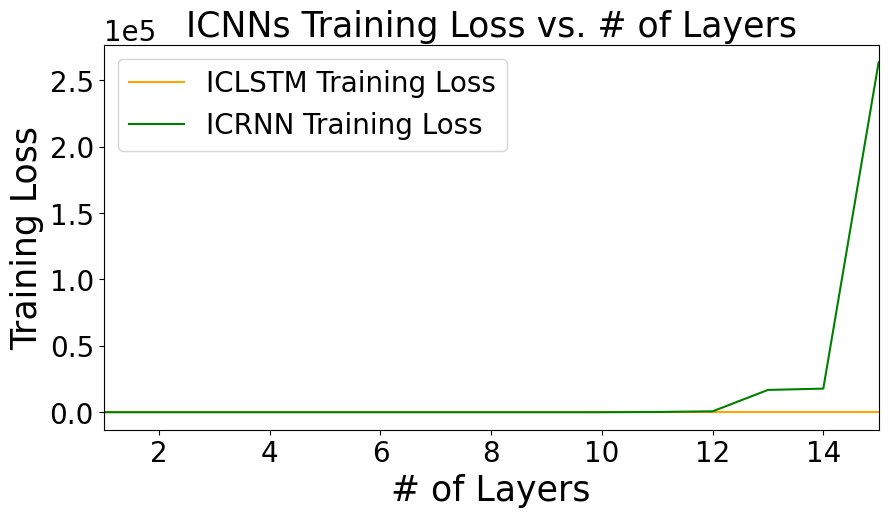

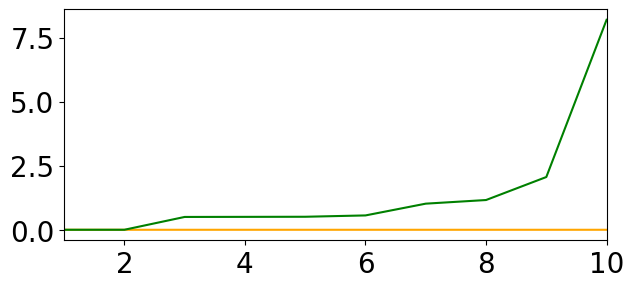

In [ ]:
# plot training loss against layers
# with open('/content/drive/MyDrive/MPC/training_loss.txt') as f:
#   training_loss = f.readlines()

# with open('/content/drive/MyDrive/MPC/training_loss_icrnn.txt') as f:
#   training_loss_icrnn = f.readlines()

training_loss = [6.318197165455786e-07, 5.113566885484033e-07, 5.151654818291718e-07, 2.103722181345802e-06, 1.1593836006795755e-06, 6.709653462166898e-06, 8.628783234598814e-07, 4.40090661868453e-06, 7.923998964542989e-06, 1.785478161764331e-05, 5.8636611356632784e-05, 0.0007131649181246758, 0.0022029313258826733, 0.0034953863359987736, 0.0010360515443608165]
training_loss_icrnn = [0.0003169380943290889, 0.0006774743087589741, 0.5005089044570923, 0.5039138197898865, 0.5078442692756653, 0.5598450899124146, 1.0190794467926025, 1.1607595682144165, 2.0582690238952637, 8.192747116088867, 186.842529296875, 662.7205200195312, 16795.25390625, 17782.05859375, 263645.25]
layers = range(1, len(training_loss) + 1)

plt.figure(figsize=(10,5))
plt.rc('font', size=20)
plt.plot(layers[0:15], training_loss[0:15], 'orange', label='ICLSTM Training Loss')
plt.plot(layers[0:15], training_loss_icrnn[0:15], 'green', label='ICRNN Training Loss')
plt.title('ICNNs Training Loss vs. # of Layers', fontsize=25)
plt.xlabel("# of Layers", fontsize=25)
plt.ylabel("Training Loss", fontsize=25)
plt.legend(loc='upper left', fontsize=20)
plt.margins(x=0)
plt.xlim([1, 15])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("/content/drive/MyDrive/MPC/training_loss.png", bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,3))
plt.plot(layers[0:10], training_loss[0:10], 'orange', label='ICLSTM Training Loss')
plt.plot(layers[0:10], training_loss_icrnn[0:10], 'green', label='ICRNN Training Loss')
# plt.title('ICNNs Training Loss vs. # of Layers')
# plt.xlabel("# of Layers")
# plt.ylabel("Training Loss")
# plt.legend()
plt.margins(x=0)
plt.xlim([1, 10])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("/content/drive/MyDrive/MPC/training_loss_enlarged.png", bbox_inches='tight')
plt.show()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

NameError: ignored

In [ ]:
# RNN model with tanh
# MSE loss 3.7448e-05
# model.save('/content/drive/MyDrive/MPC/model1.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model1.h5')

# RNN model with tanh with t_final = 0.005
# MSE loss 2.7492e-05
# model.save('/content/drive/MyDrive/MPC/model26.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model26.h5')

# skip_LSTM model with tanh
# MSE loss 2.9629e-06
# model.save('/content/drive/MyDrive/MPC/model2.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model2.h5')

# res_RNN model with relu
# MSE loss 3.6951e-05
# model.save('/content/drive/MyDrive/MPC/model3.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model3.h5')

# input_convex_LSTM model
# model.save('/content/drive/MyDrive/MPC/model4.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model4.h5')

# input_convex_1layer_LSTM model
# model.save('/content/drive/MyDrive/MPC/model5.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model5.h5')

# LSTM model with tanh
# MSE loss 9.4855e-07
# model.save('/content/drive/MyDrive/MPC/model6.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model6.h5')

# LSTM model with tanh with t_final = 0.005
# MSE loss 1.7523e-06
# model.save('/content/drive/MyDrive/MPC/model27.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model27.h5')

# input_convex_GRU model
# model.save('/content/drive/MyDrive/MPC/model7.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model7.h5')

# GRU model
# model.save('/content/drive/MyDrive/MPC/model8.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model8.h5')

# input_convex_resRNN model
# model.save('/content/drive/MyDrive/MPC/model9.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model9.h5')

# res_RNN model with tanh
# MSE loss 4.1668e-05
# model.save('/content/drive/MyDrive/MPC/model19.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model19.h5')

# res_LSTM model with relu
# MSE loss 1.0835e-06
# model.save('/content/drive/MyDrive/MPC/model20.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model20.h5')

# res_LSTM model with relu with t_final = 0.001
# MSE loss 2.4660e-06
# model.save('/content/drive/MyDrive/MPC/model29.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model29.h5')

# non-neg activation res_LSTM model with relu with t_final = 0.001
# MSE loss 6.0668e-05
# model.save('/content/drive/MyDrive/MPC/model30.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model30.h5')

# non-neg dense res_LSTM model with relu with t_final = 0.001
# MSE loss 8/4969e-05
model.save('/content/drive/MyDrive/MPC/model31.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model31.h5')

# res_LSTM model with tanh
# MSE loss 1.4391e-06
# model.save('/content/drive/MyDrive/MPC/model21.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model21.h5')

# res_LSTM_real model with elu
# MSE loss 1.1227e-05
# model.save('/content/drive/MyDrive/MPC/model22.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model22.h5')

# res_LSTM_real model with elu
# MSE loss 4.4706e-05
# model.save('/content/drive/MyDrive/MPC/model23.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model23.h5')

# 1DCNN with relu
# MSE loss 6.0135e-05
# model.save('/content/drive/MyDrive/MPC/model24.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model24.h5')

# res_1DCNN with relu
# MSE loss 8.5084e-05
# model.save('/content/drive/MyDrive/MPC/model25.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model25.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


The FLOPs is:31572


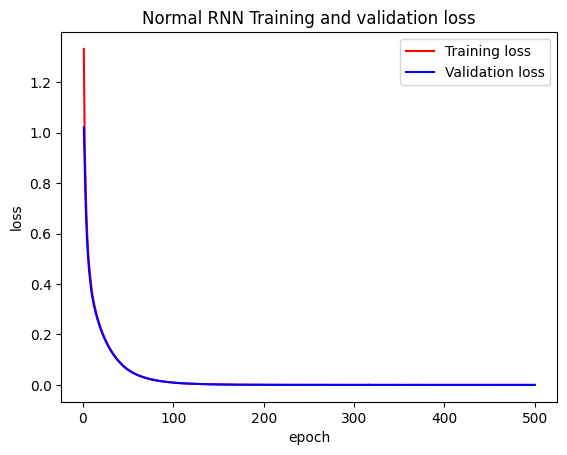

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

<ipython-input-71-dfbba1d57251>:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


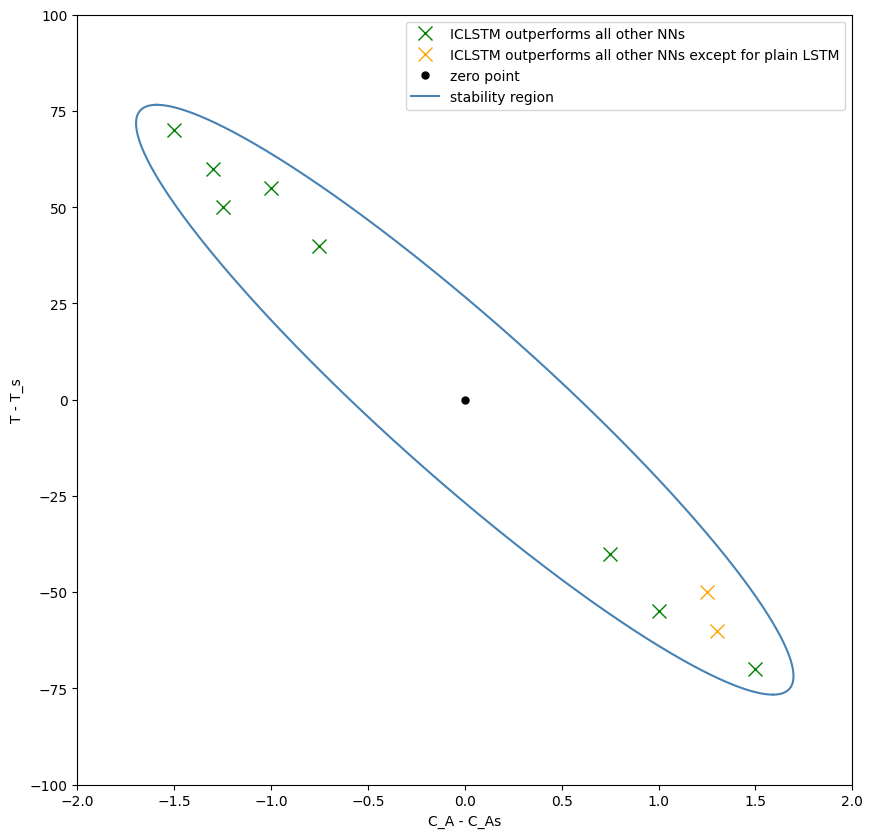

In [ ]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass


plt.figure(figsize=(10,10))

# # # plot the first 10 samples and their trajectories
# y_predict = model.predict(X_test)
# print(y_predict.shape)

# y_predict = y_predict.reshape(-1,2)
# y_predict = scaler_y.inverse_transform(y_predict)
# y_predict = y_predict.reshape(-1,num_step,2)

# X_plot = X_test.reshape(-1,num_dims)
# X_plot = scaler_X.inverse_transform(X_plot)
# X_plot = X_plot.reshape(-1,num_step,num_dims)

# for i in range(10):
#     if i == 0:  # only add label to 1 data point
#         plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
#         plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
#         plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
#     else:
#         plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
#         plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
#         plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

plt.plot(-1.5, 70, marker="x", markersize=10, color='green', label='ICLSTM outperforms all other NNs', linestyle='None')
plt.plot(1.5, -70, marker="x", markersize=10, color='green')
plt.plot(-1.25, 50, marker="x", markersize=10, color='green')
plt.plot(1.25, -50, marker="x", markersize=10, color='orange')
plt.plot(-1, 55, marker="x", markersize=10, color='green')
plt.plot(1, -55, marker="x", markersize=10, color='green')
plt.plot(-0.75, 40, marker="x", markersize=10, color='green')
plt.plot(0.75, -40, marker="x", markersize=10, color='green')
plt.plot(-1.3, 60, marker="x", markersize=10, color='green')
plt.plot(1.3, -60, marker="x", markersize=10, color='orange', label='ICLSTM outperforms all other NNs except for plain LSTM', linestyle='None')
plt.plot(0, 0, marker="o", markersize=5, color='black', label='zero point', linestyle='None')
plt.legend()

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.savefig("/content/drive/MyDrive/MPC/conditions.pdf", bbox_inches='tight')
plt.show()


In [ ]:
print(y_predict[8, :, 0])
print(y_test[8, :, 0])

[70.73037  70.07068  69.429214 68.75662  68.10353  67.448074 66.78387
 66.11156  65.43481  64.75877 ]
[70.72561539 70.07921788 69.43025205 68.77887103 68.12522131 67.46944305
 66.81167038 66.15203175 65.49065012 64.82764332]


In [ ]:
# compute deltaCA and deltaT for each time step
y_predict = model.predict(RNN_input)
print(y_predict.shape)

def euler(X, X_next):
  return (X_next - X)/t_step

CA_gradient = list()
T_gradient = list()

for i in range(y_predict.shape[0]):
  for j in range(y_predict.shape[1]-1):
    CA_gradient.append(euler(y_predict[i, j, 0], y_predict[i, j+1, 0]))
    T_gradient.append(euler(y_predict[i, j, 1], y_predict[i, j+1, 1]))

CA_gradient = np.array(CA_gradient).reshape(2000, -1)
T_gradient = np.array(T_gradient).reshape(2000, -1)
RNN_gradient = np.dstack([CA_gradient, T_gradient])
print(RNN_gradient.shape)

63/63 [==============================] - 1s 10ms/step
(2000, 20, 2)
(2000, 19, 2)


In [ ]:
class MyICNN(tf.keras.layers.Layer):

    def __init__(self, units, myInputShape, isFirstLayer, **kwargs):
        self.units = units
        self.state_size = self.units
        self.myInputShape = myInputShape
        self.isFirstLayer = isFirstLayer
        super(MyICNN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(self.myInputShape, self.units),
                                  initializer='uniform',
                                  name='kernel',
                                  constraint=tf.keras.constraints.NonNeg(),
                                  trainable=True)
        self.W = self.add_weight(shape=(input_shape[0][-1], self.units),
                                  initializer='uniform',
                                  name='W',
                                  constraint=tf.keras.constraints.NonNeg(),
                                  trainable=True)
        self.built = True

    def call(self, inputs):
        x, input = inputs
        if self.isFirstLayer is False:
          h = K.dot(x, self.W) + K.dot(input, self.kernel)
        else:
          h = K.dot(x, self.W)
        h = tf.nn.relu(h)
        return h

    def get_config(self):
        config = super(MyICNN, self).get_config()
        config.update({"units": self.units, "myInputShape": self.myInputShape, "isFirstLayer": self.isFirstLayer})
        return config

# ICNN
myInputShape = X_train.shape[1]*X_train.shape[2]
X_train_ICNN = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
y_train_ICNN = y_train.reshape(-1, y_train.shape[1]*y_train.shape[2])
input = Input(shape=(X_train.shape[1]*X_train.shape[2],))
x = MyICNN(64, myInputShape, True)([input, input])
x = MyICNN(64, myInputShape, False)([x, input])
x = Dense(y_train.shape[1] * y_train.shape[2], activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
model = Model(input, x)

# x_skip = Dense(64, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x_skip)
# x = Dense(64, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(input)
# x = Add()([x, x_skip])
# x = tf.keras.layers.ReLU()(x)
# x = Dense(64, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# x = Add()([x, x_skip])
# x = tf.keras.layers.ReLU()(x)
# x = Dense(y_train.shape[1] * y_train.shape[2], activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train_ICNN, y_train_ICNN, epochs=500, batch_size=256, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/500


26/26 - 4s - loss: 1.1808 - mean_squared_error: 1.1808 - val_loss: 0.8650 - val_mean_squared_error: 0.8650 - 4s/epoch - 139ms/step
Epoch 2/500
26/26 - 0s - loss: 0.7846 - mean_squared_error: 0.7846 - val_loss: 0.6901 - val_mean_squared_error: 0.6901 - 276ms/epoch - 11ms/step
Epoch 3/500
26/26 - 0s - loss: 0.6289 - mean_squared_error: 0.6289 - val_loss: 0.5620 - val_mean_squared_error: 0.5620 - 264ms/epoch - 10ms/step
Epoch 4/500
26/26 - 0s - loss: 0.5259 - mean_squared_error: 0.5259 - val_loss: 0.4838 - val_mean_squared_error: 0.4838 - 393ms/epoch - 15ms/step
Epoch 5/500
26/26 - 0s - loss: 0.4616 - mean_squared_error: 0.4616 - val_loss: 0.4339 - val_mean_squared_error: 0.4339 - 259ms/epoch - 10ms/step
Epoch 6/500
26/26 - 0s - loss: 0.4197 - mean_squared_error: 0.4197 - val_loss: 0.4005 - val_mean_squared_error: 0.4005 - 410ms/epoch - 16ms/step
Epoch 7/500
26/26 - 0s - loss: 0.3927 - mean_squared_error: 0.3927 - val_loss: 0.3799 - val_mean_squared_error: 0.3799 - 265ms/epoch - 10ms/step

<ipython-input-60-d8a813711312>:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 0s 2ms/step
(3706, 20)


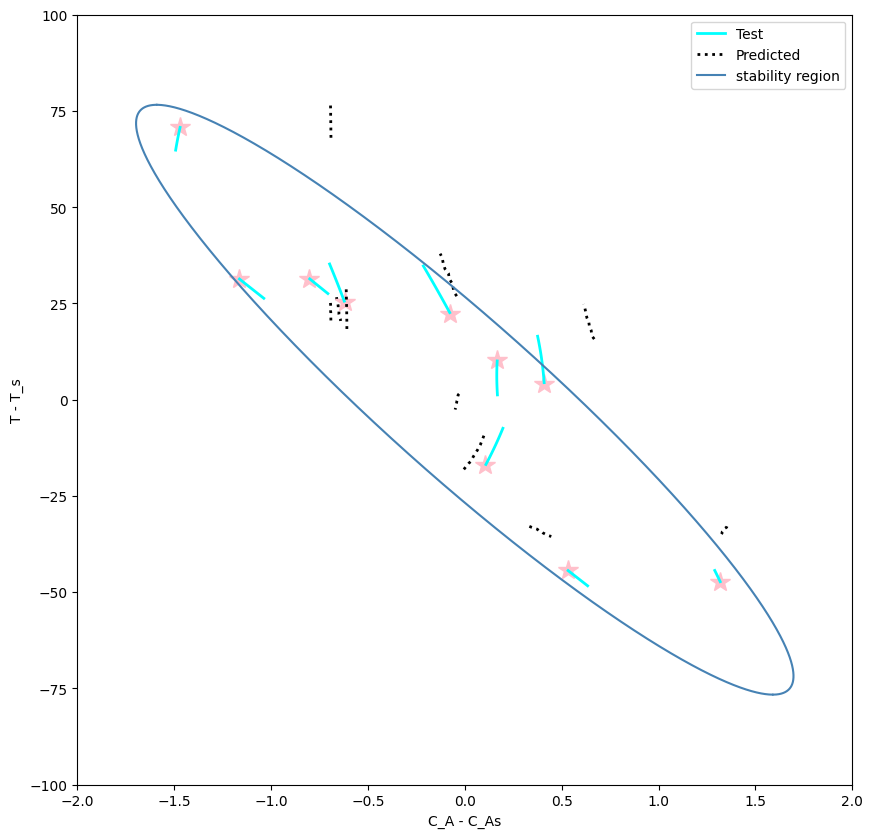

In [ ]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass

plt.figure(figsize=(10,10))

# # plot the first 10 samples and their trajectories
y_predict = model.predict(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2]))
print(y_predict.shape)

y_predict = y_predict.reshape(-1,2)
y_predict = scaler_y.inverse_transform(y_predict)
y_predict = y_predict.reshape(-1,num_step,2)

X_plot = X_test.reshape(-1,num_dims)
X_plot = scaler_X.inverse_transform(X_plot)
X_plot = X_plot.reshape(-1,num_step,num_dims)

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 1], X_plot[i, 0, 0], marker="*", markersize=15, color='pink')
        plt.plot(y_test[i, :, 1], y_test[i, :, 0], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 1], y_predict[i, :, 0], color='black', lw=2, ls=':')

# plot stability region
plt.plot(x_lower, y_plot, color='steelblue', label='stability region')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.show()

In [ ]:
# tf.random.set_seed(42)

class MyRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, input_shape_custom, **kwargs):
        self.units = units
        self.input_shape_custom = input_shape_custom
        self.state_size = [tf.TensorShape([units]), tf.TensorShape([input_shape_custom])]
        # self.state_size = self.units
        super(MyRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer='uniform',
                                                name='recurrent_kernel',
                                                constraint=tf.keras.constraints.NonNeg(),
                                                trainable=True)
        self.D1 = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='D1',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D2 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D2',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D3 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='uniform',
                                 name='D3',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units, self.units),
                                 initializer='uniform',
                                 name='V',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.built = True

    def call(self, inputs, states):
        # plain RNN
        # prev_output = states[0]
        # h = K.dot(inputs, self.kernel) + K.dot(prev_output, self.recurrent_kernel)
        # h = tf.nn.tanh(h)
        # return h, [h]

        # ICRNN
        prev_h, prev_input = states
        h = K.dot(inputs, self.kernel) + K.dot(prev_h, self.recurrent_kernel) + K.dot(prev_input, self.D2)
        h = tf.nn.elu(h)
        y = K.dot(h, self.V) + K.dot(prev_h, self.D1) + K.dot(inputs, self.D3)
        y = tf.nn.elu(y)
        return y, [h, inputs]

    def get_config(self):
        config = super(MyRNNCell, self).get_config()
        config.update({"units": self.units, "input_shape_custom": self.input_shape_custom})
        return config

training_loss_icrnn = [0] * 15
training_loss_icrnn = [0.0003169380943290889, 0.0006774743087589741, 0.5005089044570923, 0.5039138197898865, 0.5078442692756653, 0.5598450899124146, 1.0190794467926025, 1.1607595682144165, 2.0582690238952637, 8.192747116088867, 186.842529296875, 662.7205200195312, 16795.25390625, 0, 0]
for i in range(15):
  model = Sequential()
  model.add(RNN(MyRNNCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True))
  for j in range(i):
    model.add(RNN(MyRNNCell(units=64, input_shape_custom=64),return_sequences=True))
  model.add(Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg()))

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
  history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.25, verbose=2)
  model.summary()
  training_loss_icrnn[i] = history.history['loss'][-1]
  print(training_loss_icrnn)

  file = open('/content/drive/MyDrive/MPC/training_loss_icrnn.txt','w')
  for item in training_loss_icrnn:
    file.write(str(item) + "\n")
  file.close()

# MSE loss 3.4411e-04
# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x_skip = input
# x = RNN(MyRNNCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True)(input),
# x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x[0])
# x = Add()([x, x_skip])
# x = RNN(MyRNNCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True)(x),
# x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x[0])
# x = Add()([x, x_skip])
# x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# model = Model(input, x)

Epoch 1/500
26/26 - 49s - loss: 164364992512.0000 - mean_squared_error: 164365008896.0000 - val_loss: 19419598.0000 - val_mean_squared_error: 19419600.0000 - 49s/epoch - 2s/step
Epoch 2/500
26/26 - 5s - loss: 9240579.0000 - mean_squared_error: 9240579.0000 - val_loss: 5167843.5000 - val_mean_squared_error: 5167843.5000 - 5s/epoch - 194ms/step
Epoch 3/500
26/26 - 8s - loss: 5036931.0000 - mean_squared_error: 5036931.5000 - val_loss: 4613600.5000 - val_mean_squared_error: 4613600.5000 - 8s/epoch - 316ms/step
Epoch 4/500
26/26 - 5s - loss: 4810980.0000 - mean_squared_error: 4810979.5000 - val_loss: 4567097.0000 - val_mean_squared_error: 4567096.5000 - 5s/epoch - 198ms/step
Epoch 5/500
26/26 - 8s - loss: 4787660.5000 - mean_squared_error: 4787660.5000 - val_loss: 4556869.0000 - val_mean_squared_error: 4556869.0000 - 8s/epoch - 300ms/step
Epoch 6/500
26/26 - 5s - loss: 4778356.5000 - mean_squared_error: 4778356.5000 - val_loss: 4548513.5000 - val_mean_squared_error: 4548513.5000 - 5s/epoch 

In [ ]:
# my tanh ICRNN
# MSE loss 7.9917e-04
# model.save('/content/drive/MyDrive/MPC/model10.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model10.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my relu ICRNN
# MSE loss 0.0017
# model.save('/content/drive/MyDrive/MPC/model13.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model13.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my elu ICRNN
# MSE loss 0.0020
# model.save('/content/drive/MyDrive/MPC/model14.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model14.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my elu ICRNN with t_final = 0.005
# MSE loss 4.7460e-04
# model.save('/content/drive/MyDrive/MPC/model28.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model28.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my relu ICRNN with t_final = 0.005
# MSE loss 3.7069e-04
# model.save('/content/drive/MyDrive/MPC/model32.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model32.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my relu ICNN with t_final = 0.005
# MSE loss 8.1487e-05
# model.save('/content/drive/MyDrive/MPC/model33.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model33.h5')

# my relu ICNN with t_final = 0.005
# MSE loss 0.0766
model.save('/content/drive/MyDrive/MPC/model34.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model33.h5', custom_objects={"MyICNN": MyICNN})

# my tanh plain RNN
# MSE loss 7.9252e-04
# model.save('/content/drive/MyDrive/MPC/model11.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model11.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh res model with plain RNN
# MSE loss 4.0038e-04
# model.save('/content/drive/MyDrive/MPC/model3.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model3.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh res ICRNN model with ICRNN
# MSE loss 4.3711e-04
# model.save('/content/drive/MyDrive/MPC/model12.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model12.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh res model with plain RNN using 3 layers
# MSE loss 4.8507e-04
# model.save('/content/drive/MyDrive/MPC/model16.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model16.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh plain LSTM
# MSE loss 8.4152e-06
# model.save('/content/drive/MyDrive/MPC/model17.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model17.h5', custom_objects={"MyRNNCell": MyRNNCell})

# my tanh res model with plain LSTM
# MSE loss 1.8458e-04
# model.save('/content/drive/MyDrive/MPC/model18.h5')
# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model18.h5', custom_objects={"MyRNNCell": MyRNNCell})

# model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model0.h5')

In [ ]:
model.summary()
print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 64)                   5184      ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 64)                   5184      ['input_1[0][0]']             
                                                                                                  
 add (Add)                   (None, 64)                   0         ['dense_1[0][0]',             
                                                                     'dense[0][0]']           

In [ ]:
class MyLSTMCell(tf.keras.layers.Layer):

    def __init__(self, units, input_shape_custom, **kwargs):
        self.units = units
        self.input_shape_custom = input_shape_custom
        self.state_size = [self.units, self.units]
        super(MyLSTMCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1] + self.units, 4 * self.units),
                                      initializer='uniform',
                                      name='kernel',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.built = True

    def call(self, inputs, states):
        h_tm1 = states[0]  # previous hidden state
        c_tm1 = states[1]  # previous cell state

        combined_inputs = tf.matmul(tf.concat([inputs, h_tm1], axis=-1), self.kernel)
        i, f, o, g = tf.split(combined_inputs, num_or_size_splits=4, axis=1)

        i = tf.nn.sigmoid(i)
        f = tf.nn.sigmoid(f)
        o = tf.nn.sigmoid(o)
        g = tf.nn.tanh(g)

        new_c = f * c_tm1 + i * g
        new_h = o * tf.nn.tanh(new_c)

        return new_h, [new_h, new_c]

    def get_config(self):
        config = super(MyLSTMCell, self).get_config()
        config.update({"units": self.units, "input_shape_custom": self.input_shape_custom})
        return config

model = tf.keras.Sequential([
    tf.keras.layers.RNN(MyLSTMCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True),
    tf.keras.layers.RNN(MyLSTMCell(units=64, input_shape_custom=64),return_sequences=True),
    tf.keras.layers.Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())
])

# input = Input(shape=(X_train.shape[1],X_train.shape[2]))
# x_skip = input
# x = RNN(MyLSTMCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True)(input),
# x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x[0])
# x = Add()([x, x_skip])
# x = RNN(MyLSTMCell(units=64, input_shape_custom=X_train.shape[2]),return_sequences=True)(x),
# x = Dense(X_train.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x[0])
# x = Add()([x, x_skip])
# x = Dense(2, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
# model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/1000
26/26 - 4s - loss: 1.0023 - mean_squared_error: 1.0023 - val_loss: 0.9933 - val_mean_squared_error: 0.9933 - 4s/epoch - 151ms/step
Epoch 2/1000
26/26 - 3s - loss: 1.0022 - mean_squared_error: 1.0022 - val_loss: 0.9935 - val_mean_squared_error: 0.9935 - 3s/epoch - 106ms/step
Epoch 3/1000
26/26 - 2s - loss: 1.0022 - mean_squared_error: 1.0022 - val_loss: 0.9936 - val_mean_squared_error: 0.9936 - 2s/epoch - 73ms/step
Epoch 4/1000
26/26 - 2s - loss: 1.0022 - mean_squared_error: 1.0022 - val_loss: 0.9937 - val_mean_squared_error: 0.9937 - 2s/epoch - 66ms/step
Epoch 5/1000
26/26 - 2s - loss: 1.0022 - mean_squared_error: 1.0022 - val_loss: 0.9938 - val_mean_squared_error: 0.9938 - 2s/epoch - 63ms/step
Epoch 6/1000
26/26 - 2s - loss: 1.0022 - mean_squared_error: 1.0022 - val_loss: 0.9939 - val_mean_squared_error: 0.9939 - 2s/epoch - 70ms/step
Epoch 7/1000
26/26 - 2s - loss: 1.0022 - mean_squared_error: 1.0022 - val_loss: 0.9938 - val_mean_squared_error: 0.9938 - 2s/epoch - 70ms/st

KeyboardInterrupt: ignored

In [ ]:
class CNN1D(tf.keras.Model):
  def __init__(self, num_neurons, kernel_size, len_sequence, num_feature, output_shape):
    super(CNN1D, self).__init__()
    self.cnn1 = tf.keras.layers.Conv1D(filters=num_neurons, kernel_size=kernel_size, activation='relu', input_shape=(len_sequence,num_feature))
    self.maxpool1 = tf.keras.layers.MaxPooling1D(pool_size=2)
    self.cnn2 = tf.keras.layers.Conv1D(filters=num_neurons, kernel_size=kernel_size, activation='relu')
    self.maxpool2 = tf.keras.layers.MaxPooling1D(pool_size=2)
    self.flatten1 = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(128,activation='relu')
    self.dense2 = tf.keras.layers.Dense(len_sequence * output_shape, activation='linear')
    self.reshape1 = tf.keras.layers.Reshape((len_sequence, output_shape))

  def call(self, input_tensor):
    x = self.cnn1(input_tensor)
    x = self.maxpool1(x)

    x = self.cnn2(x)
    x = self.maxpool2(x)

    x = self.flatten1(x)
    x = self.dense1(x)
    x = self.dense2(x)

    output = self.reshape1(x)
    return output

model = CNN1D(num_neurons=64, kernel_size=3, len_sequence=X_train.shape[1], num_feature=X_train.shape[2], output_shape=y_train.shape[2])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/500
26/26 - 6s - loss: 0.4182 - mean_squared_error: 0.4182 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - 6s/epoch - 214ms/step
Epoch 2/500
26/26 - 0s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - 423ms/epoch - 16ms/step
Epoch 3/500
26/26 - 0s - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - 420ms/epoch - 16ms/step
Epoch 4/500
26/26 - 0s - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - 445ms/epoch - 17ms/step
Epoch 5/500
26/26 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - 437ms/epoch - 17ms/step
Epoch 6/500


KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
from keras.layers import Input
from keras import Model

class residualLSTM(tf.keras.Model):
  def __init__(self, num_neurons, input_shape, output_shape):
    super(residualLSTM, self).__init__()
    self.lstm1 = tf.keras.layers.LSTM(num_neurons, activation='elu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())
    self.dense1 = tf.keras.layers.Dense(input_shape, activation=None, kernel_constraint=tf.keras.constraints.NonNeg())
    self.skip1 = tf.keras.layers.Add()
    self.activation1 = tf.keras.layers.Activation('elu')

    self.lstm2 = tf.keras.layers.LSTM(num_neurons, activation='elu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())
    self.dense2 = tf.keras.layers.Dense(input_shape, activation=None, kernel_constraint=tf.keras.constraints.NonNeg())
    self.skip2 = tf.keras.layers.Add()
    self.activation2 = tf.keras.layers.Activation('elu')

    self.dense3 = tf.keras.layers.Dense(output_shape, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())

  def call(self, input_tensor):
    x = self.lstm1(input_tensor)
    x = self.dense1(x)
    x = self.skip1([x, input_tensor])
    x = self.activation1(x)

    x = self.lstm2(x)
    x = self.dense2(x)
    x = self.skip2([x, input_tensor])
    x = self.activation2(x)

    output = self.dense3(x)
    return output

class residualRNN(tf.keras.Model):
  def __init__(self, num_neurons, input_shape, output_shape):
    super(residualRNN, self).__init__()
    self.rnn1 = tf.keras.layers.SimpleRNN(num_neurons, activation='elu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())
    self.dense1 = tf.keras.layers.Dense(input_shape, activation=None, kernel_constraint=tf.keras.constraints.NonNeg())
    self.skip1 = tf.keras.layers.Add()
    self.activation1 = tf.keras.layers.Activation('elu')

    self.rnn2 = tf.keras.layers.SimpleRNN(num_neurons, activation='elu', return_sequences=True, kernel_constraint=tf.keras.constraints.NonNeg())
    self.dense2 = tf.keras.layers.Dense(input_shape, activation=None, kernel_constraint=tf.keras.constraints.NonNeg())
    self.skip2 = tf.keras.layers.Add()
    self.activation2 = tf.keras.layers.Activation('elu')

    self.dense3 = tf.keras.layers.Dense(output_shape, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())

  def call(self, input_tensor):
    x = self.rnn1(input_tensor)
    x = self.dense1(x)
    x = self.skip1([x, input_tensor])
    x = self.activation1(x)

    x = self.rnn2(x)
    x = self.dense2(x)
    x = self.skip2([x, input_tensor])
    x = self.activation2(x)

    output = self.dense3(x)
    return output

input = Input(shape=(X_train.shape[1],X_train.shape[2]))
x = residualLSTM(num_neurons=64, input_shape=8, output_shape=2)(input)
# x = residualRNN(num_neurons=64, input_shape=8, output_shape=2)(input)
model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/500
26/26 - 7s - loss: 1.3295 - mean_squared_error: 1.3295 - val_loss: 0.9097 - val_mean_squared_error: 0.9097 - 7s/epoch - 267ms/step
Epoch 2/500
26/26 - 4s - loss: 0.7421 - mean_squared_error: 0.7421 - val_loss: 0.6021 - val_mean_squared_error: 0.6021 - 4s/epoch - 161ms/step
Epoch 3/500
26/26 - 6s - loss: 0.4816 - mean_squared_error: 0.4816 - val_loss: 0.3466 - val_mean_squared_error: 0.3466 - 6s/epoch - 231ms/step
Epoch 4/500
26/26 - 2s - loss: 0.2937 - mean_squared_error: 0.2937 - val_loss: 0.2493 - val_mean_squared_error: 0.2493 - 2s/epoch - 93ms/step
Epoch 5/500
26/26 - 2s - loss: 0.2247 - mean_squared_error: 0.2247 - val_loss: 0.1995 - val_mean_squared_error: 0.1995 - 2s/epoch - 89ms/step
Epoch 6/500
26/26 - 2s - loss: 0.1840 - mean_squared_error: 0.1840 - val_loss: 0.1671 - val_mean_squared_error: 0.1671 - 2s/epoch - 92ms/step
Epoch 7/500
26/26 - 2s - loss: 0.1556 - mean_squared_error: 0.1556 - val_loss: 0.1421 - val_mean_squared_error: 0.1421 - 2s/epoch - 91ms/step
Epo

In [ ]:
class resCNN1D(tf.keras.Model):
  def __init__(self, num_neurons, kernel_size, len_sequence, num_feature, output_shape):
    super(resCNN1D, self).__init__()
    self.cnn_input = tf.keras.layers.Conv1D(filters=num_neurons, kernel_size=1, padding='same', input_shape=(len_sequence,num_feature))
    self.cnn1 = tf.keras.layers.Conv1D(filters=num_neurons, kernel_size=kernel_size, padding='same', activation='relu', input_shape=(len_sequence,num_feature))
    self.skip1 = tf.keras.layers.Add()
    self.cnn2 = tf.keras.layers.Conv1D(filters=num_neurons, kernel_size=kernel_size, padding='same', activation='relu')
    self.skip2 = tf.keras.layers.Add()

    self.flatten1 = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(256,activation='relu')
    self.dense2 = tf.keras.layers.Dense(len_sequence * output_shape, activation='linear')
    self.reshape1 = tf.keras.layers.Reshape((len_sequence, output_shape))

  def call(self, input_tensor):
    input = self.cnn_input(input_tensor)
    x = self.cnn1(input_tensor)
    x = self.skip1([x, input])

    x = self.cnn2(x)
    x = self.skip2([x, input])

    x = self.flatten1(x)
    x = self.dense1(x)
    x = self.dense2(x)

    output = self.reshape1(x)
    return output

model = resCNN1D(num_neurons=64, kernel_size=3, len_sequence=X_train.shape[1], num_feature=X_train.shape[2], output_shape=y_train.shape[2])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/500
26/26 - 3s - loss: 0.1676 - mean_squared_error: 0.1676 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - 3s/epoch - 123ms/step
Epoch 2/500
26/26 - 1s - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - 1s/epoch - 56ms/step
Epoch 3/500
26/26 - 1s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - 1s/epoch - 52ms/step
Epoch 4/500


KeyboardInterrupt: ignored